In [1]:
import pandas as pd
acctDF = pd.read_parquet("data/q2-ucsd-acctDF.pqt")
cat_map = pd.read_csv('data/q2-ucsd-cat-map.csv')
consDF = pd.read_parquet('data/q2-ucsd-consDF.pqt')
trxnDF = pd.read_parquet('data/q2-ucsd-trxnDF.pqt')

FileNotFoundError: [Errno 2] No such file or directory: 'data/q2-ucsd-acctDF.pqt'

In [2]:
def convert_credit_to_debit(row):
    if row['amount'] < 0:
        row['amount'] *=-1
        if row['credit_or_debit'] == 'CREDIT':
            row['credit_or_debit'] = 'DEBIT'
        else:
            row['credit_or_debit'] = 'CREDIT'
    return row

trxnDF[trxnDF['amount'] < 0]
most_important_accounts = ['CHECKING', 'SAVINGS', 'CREDIT CARD', 'LOAN']
acct = acctDF[acctDF['account_type'].isin(most_important_accounts)]
acct = acct.groupby('prism_consumer_id').balance.sum()
df = pd.DataFrame(acct).merge(consDF, on='prism_consumer_id', how='outer')
df
trxnDF

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [3]:
trxn = trxnDF.copy()
df=trxn.groupby(['prism_consumer_id', 'credit_or_debit'], as_index = False).amount.sum()
df

,prism_consumer_id,credit_or_debit,amount
0,0,CREDIT,14386.82
1,0,DEBIT,14908.41
2,1,CREDIT,24903.80
3,1,DEBIT,23098.37
4,10,CREDIT,20576.56
...,...,...,...
28667,9997,DEBIT,16702.92
28668,9998,CREDIT,14566.37
28669,9998,DEBIT,15399.47
28670,9999,CREDIT,31777.82


In [4]:
credit = df[df.credit_or_debit == 'CREDIT'].drop(columns=['credit_or_debit']).rename(columns={'amount' : 'credit_amount'})
debit = df[df.credit_or_debit == 'DEBIT'].drop(columns=['credit_or_debit']).rename(columns={'amount' : 'debit_amount'})
normal_df = credit.merge(debit, on='prism_consumer_id', how='outer')
normal_df

,prism_consumer_id,credit_amount,debit_amount
0,0,14386.82,14908.41
1,1,24903.80,23098.37
2,10,20576.56,21766.60
3,100,35236.84,39742.61
4,1000,78353.07,77914.99
...,...,...,...
14487,9995,16925.84,17047.39
14488,9996,1200.03,1190.89
14489,9997,17206.11,16702.92
14490,9998,14566.37,15399.47


In [5]:
normal_df['credit_percentage'] = (normal_df['credit_amount']/(normal_df['credit_amount'] + normal_df['debit_amount']))
normal_df = normal_df.dropna()
normal_df

,prism_consumer_id,credit_amount,debit_amount,credit_percentage
0,0,14386.82,14908.41,0.491098
1,1,24903.80,23098.37,0.518806
2,10,20576.56,21766.60,0.485948
3,100,35236.84,39742.61,0.469953
4,1000,78353.07,77914.99,0.501402
...,...,...,...,...
14487,9995,16925.84,17047.39,0.498211
14488,9996,1200.03,1190.89,0.501911
14489,9997,17206.11,16702.92,0.507420
14490,9998,14566.37,15399.47,0.486099


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
new_df = normal_df.merge(consDF, on='prism_consumer_id', how='outer')[['prism_consumer_id', 'credit_percentage', 'DQ_TARGET']]

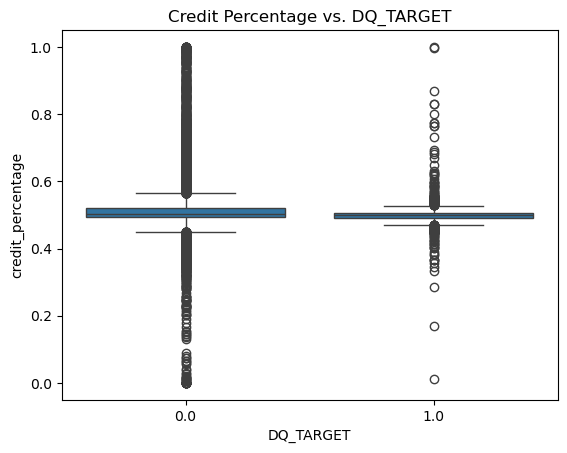

In [7]:
sns.boxplot(x='DQ_TARGET', y='credit_percentage', data=new_df)
plt.title('Credit Percentage vs. DQ_TARGET')
plt.show()

In [8]:
#normal_df[normal_df['credit_percentage'] == normal_df['credit_percentage'].min()]
def get_cat_percent(df):
    user_cat = df.groupby(['prism_consumer_id', 'category']).amount.sum().reset_index()
    pivot_df = user_cat.pivot(index='prism_consumer_id', columns='category', values='amount')
    pivot_df.fillna(0, inplace=True)
    pivot_df['total'] = pivot_df.sum(axis=1) 
    for i in (user_cat.category.unique()):
        pivot_df[i] = (pivot_df[i]/pivot_df['total']) * 100
        pivot_df = pivot_df.rename(columns={i : cat_map.loc[i].category})
    cat_percent = consDF.merge(pivot_df, on='prism_consumer_id', how='outer').drop(columns=['evaluation_date', 'credit_score'])
    cat_percent = cat_percent[cat_percent['DQ_TARGET'].notna()]
    return cat_percent

credit_trxn = trxn[trxn['credit_or_debit'] == 'CREDIT']
debit_trxn = trxn[trxn['credit_or_debit'] == 'DEBIT']

credit_cat_features = get_cat_percent(credit_trxn)
debit_cat_features = get_cat_percent(debit_trxn)
trxn_cat_features = get_cat_percent(trxn)

In [9]:
credit_cat_features

,prism_consumer_id,DQ_TARGET,SELF_TRANSFER,EXTERNAL_TRANSFER,DEPOSIT,PAYCHECK,MISCELLANEOUS,REFUND,INVESTMENT_INCOME,OTHER_BENEFITS,UNEMPLOYMENT_BENEFITS,TAX,LOAN,INSURANCE,INVESTMENT,GAMBLING,CORPORATE_PAYMENTS,TIME_OR_STUFF,PENSION,total
0,0,0.0,15.377964,1.589997,3.475403,61.310005,0.011330,0.138738,0.0,0.0,0.0,18.096563,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,14386.82
1,1,0.0,36.552655,0.000000,5.994868,47.858720,0.246509,0.009717,0.0,0.0,0.0,9.337531,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,24903.80
2,10,0.0,9.236481,15.337841,3.401929,71.541307,0.033728,0.448714,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,20576.56
3,100,0.0,21.994027,8.684093,0.000000,69.279141,0.009394,0.033346,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,35236.84
4,1000,0.0,22.663617,1.712977,6.024014,55.720344,0.330453,0.001748,0.0,0.0,0.0,0.000000,0.0,0.000000,13.546846,0.0,0.0,0.000000,0.0,78353.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,995,0.0,23.463758,2.063436,5.587765,62.989749,0.003358,0.016470,0.0,0.0,0.0,5.875464,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,53309.15
14956,996,0.0,95.891974,0.000000,0.978899,0.863207,0.119818,0.011885,0.0,0.0,0.0,0.000000,0.0,2.134217,0.000000,0.0,0.0,0.000000,0.0,222962.79
14967,997,0.0,43.127697,0.005833,2.465436,48.605919,0.009580,0.065370,0.0,0.0,0.0,3.801929,0.0,0.000000,0.000000,0.0,0.0,1.918236,0.0,66176.94
14978,998,0.0,28.819821,4.316839,0.142230,53.979168,0.042083,0.186363,0.0,0.0,0.0,12.513494,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,71714.74


In [10]:
debit_cat_features

,prism_consumer_id,DQ_TARGET,SELF_TRANSFER,EXTERNAL_TRANSFER,MISCELLANEOUS,TAX,LOAN,INSURANCE,FOOD_AND_BEVERAGES,GENERAL_MERCHANDISE,...,FITNESS,TRANSPORATION,LEGAL,GOVERNMENT_SERVICES,RISK_CATCH_ALL,RTO_LTO,INVESTMENT,GAMBLING,CORPORATE_PAYMENTS,total
0,0,0.0,3.161772,11.678643,11.171614,0.0,0.000000,0.000000,27.362744,13.240849,...,1.010168,0.016635,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,14908.41
1,1,0.0,39.409707,0.010477,7.676992,0.0,0.000000,0.000000,1.458977,14.349627,...,0.000000,0.224258,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,23098.37
2,10,0.0,8.731497,36.005440,4.447456,0.0,0.000000,0.000000,15.382007,7.401983,...,0.000000,0.160981,0.0,0.000000,0.0,0.0,0.000000,0.762636,0.0,21766.60
3,100,0.0,30.075227,20.793803,1.991565,0.0,0.000000,4.888355,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,39742.61
4,1000,0.0,63.383067,3.619381,9.320183,0.0,3.065058,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.411795,0.000000,0.0,77914.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,995,0.0,0.003305,15.565426,1.001860,0.0,8.258314,1.129043,0.000000,3.269893,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,31466.47
14956,996,0.0,40.440671,24.721241,2.434940,0.0,0.973801,0.000000,1.257495,0.704633,...,0.000000,0.006115,0.0,0.920970,0.0,0.0,1.528665,0.154395,0.0,196249.61
14967,997,0.0,40.196037,33.359564,1.403463,0.0,0.000000,0.000000,0.000000,0.034844,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.921955,0.0,81076.60
14978,998,0.0,28.437155,19.236528,2.137931,0.0,4.789523,1.582038,3.191173,13.068374,...,0.114021,0.095911,0.0,0.060417,0.0,0.0,0.000000,1.447732,0.0,66207.01


In [11]:
trxn_cat_features

,prism_consumer_id,DQ_TARGET,SELF_TRANSFER,EXTERNAL_TRANSFER,DEPOSIT,PAYCHECK,MISCELLANEOUS,REFUND,INVESTMENT_INCOME,OTHER_BENEFITS,...,LEGAL,GOVERNMENT_SERVICES,RISK_CATCH_ALL,RTO_LTO,INVESTMENT,GAMBLING,CORPORATE_PAYMENTS,TIME_OR_STUFF,PENSION,total
0,0,0.0,9.161116,6.724132,1.706763,30.109202,5.690824,0.068134,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,29295.23
1,1,0.0,37.927452,0.005041,3.110172,24.829378,3.822015,0.005041,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,48002.17
2,10,0.0,8.976893,25.962068,1.653160,34.765332,2.302615,0.218052,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.392035,0.0,0.000000,0.0,42343.16
3,100,0.0,26.277440,15.102805,0.000000,32.557961,1.060037,0.015671,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,74979.45
4,1000,0.0,42.966266,2.663507,3.020451,27.938275,4.812717,0.000877,0.0,0.0,...,0.0,0.000000,0.0,0.0,7.496330,0.000000,0.0,0.000000,0.0,156268.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,995,0.0,14.755858,7.075018,3.513734,39.609619,0.373975,0.010357,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,84775.62
14956,996,0.0,69.933065,11.572974,0.520638,0.459106,1.203617,0.006321,0.0,0.0,...,0.0,0.431142,0.0,0.0,0.715628,0.072278,0.0,0.000000,0.0,419212.40
14967,997,0.0,41.513549,18.370125,1.107987,21.843896,0.777041,0.029378,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.507621,0.0,0.862071,0.0,147253.54
14978,998,0.0,28.636129,11.478784,0.073955,28.067379,1.048160,0.096903,0.0,0.0,...,0.0,0.029002,0.0,0.0,0.000000,0.694959,0.0,0.000000,0.0,137921.75


In [12]:
deliq = trxn_cat_features[trxn_cat_features['DQ_TARGET'] ==1.0]
non_deliq = trxn_cat_features[trxn_cat_features['DQ_TARGET'] ==0.0]

In [13]:
deliq['SELF_TRANSFER'].describe()['mean']

12.392188029265798

In [14]:
biggest_difference = 0
for i in trxn_cat_features.columns:
    if i not in ['prism_consumer_id', 'DQ_TARGET', 'total']:
        deliq_desc = deliq[i].describe()
        non_desc = non_deliq[i].describe()
        if np.abs(deliq_desc['mean'] - non_desc['mean']):
            biggest_difference = np.abs(deliq_desc['mean'] - non_desc['mean'])
            category_diff = i
            diff_desc = f"{i} DESCRIPTION\n\nDeliquent:\n{deliq_desc}\n\nNon_Deliquent:\n{non_desc}\n\n"
        #print(f"{i} DESCRIPTION\n\nDeliquent:\n{deliq_desc}\n\nNon_Deliquent:\n{non_desc}\n\n")
print(diff_desc)

PENSION DESCRIPTION

Deliquent:
count    948.000000
mean       0.517900
std        3.392267
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       48.197283
Name: PENSION, dtype: float64

Non_Deliquent:
count    10648.000000
mean         0.936789
std          5.190354
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.974391
Name: PENSION, dtype: float64




In [15]:
deliq['SELF_TRANSFER'].describe()

count    948.000000
mean      12.392188
std       17.513604
min        0.000000
25%        0.000000
50%        2.064362
75%       20.905186
max      100.000000
Name: SELF_TRANSFER, dtype: float64

In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

cat_train_test = trxn_cat_features.copy()
cat_train_test = cat_train_test.dropna()
lst = []
for i in cat_train_test.columns:
    if i not in ['prism_consumer_id', 'DQ_TARGET', 'total']:
        lst.append(i)

consDF_no_null = consDF.copy().dropna()
new_df = new_df.dropna()
X = new_df['credit_percentage'].values.reshape(-1,1)#cat_train_test[lst]
y = new_df['DQ_TARGET'].values#cat_train_test['DQ_TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logr = linear_model.LogisticRegression(class_weight = 'balanced')
logr.fit(X_train, y_train)
pred = logr.predict(X_test)

report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.37      0.53      2072
         1.0       0.11      0.83      0.20       201

    accuracy                           0.41      2273
   macro avg       0.53      0.60      0.36      2273
weighted avg       0.88      0.41      0.50      2273



In [17]:
new_df = new_df[(new_df['DQ_TARGET'].notna()) & (new_df['credit_percentage'].notna())]
new_df

,prism_consumer_id,credit_percentage,DQ_TARGET
0,0,0.491098,0.0
1,1,0.518806,0.0
2,10,0.485948,0.0
3,100,0.469953,0.0
4,1000,0.501402,0.0
...,...,...,...
14945,995,0.628826,0.0
14956,996,0.531861,0.0
14967,997,0.449408,0.0
14978,998,0.519967,0.0


In [18]:
consDF
new_df

,prism_consumer_id,credit_percentage,DQ_TARGET
0,0,0.491098,0.0
1,1,0.518806,0.0
2,10,0.485948,0.0
3,100,0.469953,0.0
4,1000,0.501402,0.0
...,...,...,...
14945,995,0.628826,0.0
14956,996,0.531861,0.0
14967,997,0.449408,0.0
14978,998,0.519967,0.0


In [19]:
trxnDF[(trxnDF['credit_or_debit'] == 'DEBIT') & (trxn['prism_consumer_id'] == '0')]
trxnDF

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [20]:
trxn_time = trxnDF.copy()
trxn_time.loc[trxn_time['credit_or_debit'] == 'DEBIT', 'amount'] *= -1
trxn_time = trxn_time.groupby(['prism_consumer_id']).agg(total_amount=('amount', 'sum'), 
                                                           first_date=('posted_date', 'min'), last_date=('posted_date','max'))
trxn_time

,total_amount,first_date,last_date
prism_consumer_id,,,
0,-521.59,2021-03-16,2021-09-11
1,1805.43,2021-01-15,2021-07-14
10,-1190.04,2021-08-17,2022-02-13
100,-4505.77,2022-08-01,2023-01-27
1000,438.08,2022-08-31,2023-02-27
...,...,...,...
9995,-121.55,2022-12-05,2023-03-01
9996,9.14,2023-07-21,2023-10-07
9997,503.19,2023-02-27,2023-05-25


In [21]:
trxn_time['last_date'] = pd.to_datetime(trxn_time['last_date'])
trxn_time['first_date'] = pd.to_datetime(trxn_time['first_date'])
trxn_time['total_days'] = (trxn_time['last_date'] - trxn_time['first_date']).dt.days
trxn_time['amount_per_day'] = trxn_time['total_amount'] / trxn_time['total_days']
trxn_time
df = trxn_time.merge(consDF, left_index=True, right_on='prism_consumer_id', how='outer')
df = df.dropna()
df

,total_amount,first_date,last_date,total_days,amount_per_day,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,-521.59,2021-03-16,2021-09-11,179.0,-2.913911,0,2021-09-01,726.0,0.0
1,1805.43,2021-01-15,2021-07-14,180.0,10.030167,1,2021-07-01,626.0,0.0
10,-1190.04,2021-08-17,2022-02-13,180.0,-6.611333,10,2022-02-01,654.0,0.0
100,-4505.77,2022-08-01,2023-01-27,179.0,-25.171899,100,2021-12-01,750.0,0.0
1000,438.08,2022-08-31,2023-02-27,180.0,2.433778,1000,2021-03-01,756.0,0.0
...,...,...,...,...,...,...,...,...,...
995,21842.68,2021-05-08,2021-11-04,180.0,121.348222,995,2021-11-01,728.0,0.0
996,26713.18,2020-12-20,2021-06-18,180.0,148.406556,996,2021-06-01,729.0,0.0
997,-14899.66,2021-10-25,2022-04-21,178.0,-83.705955,997,2022-04-01,809.0,0.0
998,5507.73,2021-10-21,2022-04-19,180.0,30.598500,998,2022-04-01,651.0,0.0


In [22]:
running_total = trxnDF.copy()
running_total = running_total.sort_values('posted_date') 
running_total.loc[running_total['credit_or_debit'] == 'DEBIT', 'amount'] *= -1 
running_total['running_total'] = running_total.groupby('prism_consumer_id')['amount'].cumsum()
running_total.groupby('prism_consumer_id').agg({'running_total': ['mean', 'median', 'sum', 'var']})

running_total                                   
                           mean    median        sum           var
prism_consumer_id                                                 
0                    -50.447451  -280.125  -20582.56  9.930801e+05
1                   1603.886975  1672.940  503620.51  1.388185e+06
10                  -904.718299  -914.070 -308508.94  2.766771e+05
100                -4361.627623 -4777.250 -532118.57  4.630256e+06
1000                 870.001706   620.340  183570.36  2.461238e+06
...                         ...       ...        ...           ...
9995                 107.025563    -6.090   33284.95  1.517001e+05
9996                -104.670714   -92.020   -4396.17  6.033767e+03
9997                 309.551226   140.460   80792.87  3.139002e+05
9998                 -67.403091    -3.585  -14828.68  3.470503e+05
9999                 837.341155   648.610  319026.98  1.156338e+06

[14492 rows x 4 columns]

In [64]:
def running_total_statistics(df, time_frame='1D'):
    df['posted_date'] = pd.to_datetime(df['posted_date'])
    df.loc[df['credit_or_debit'] == 'DEBIT', 'amount'] *= -1 
    df = df.groupby(['prism_consumer_id', pd.Grouper(key='posted_date', freq=time_frame)]).amount.sum().reset_index()
    df = df.sort_values('posted_date') 
    df['running_total'] = df.groupby('prism_consumer_id')['amount'].cumsum()
    new_df = df.groupby('prism_consumer_id').agg({'running_total': ['mean', 'median', 'var']})
    new_df.columns = [f'{time_frame}_mean', f'{time_frame}_median', f'{time_frame}_var']
    return new_df

In [65]:
month = running_total_statistics(trxnDF.copy(), time_frame='1M')
week = running_total_statistics(trxnDF.copy(), time_frame='1W')
day = running_total_statistics(trxnDF.copy(), time_frame='1D')
all_features = month.merge(week, left_index=True, right_index=True)
all_features = all_features.merge(day, left_index=True, right_index=True)

/tmp/ipykernel_382/573342357.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.groupby(['prism_consumer_id', pd.Grouper(key='posted_date', freq=time_frame)]).amount.sum().reset_index()


In [ ]:
week

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import warnings


def run_classification(
    feature_column, target_column, dataset, test_size=0.2, random_state=42
):
    """
    Run Logistic Regression and Random Forest Classification on a dataset.

    Parameters:
        feature_column (list): List of columns that can be used as features.
        target_column (str): The name of the target column.
        dataset (pd.DataFrame): The dataset containing the features and target.
        test_size (float): Proportion of the dataset to include in the test split (default 0.3).
        random_state (int): Random seed for reproducibility (default 42).

    Returns:
        None: Prints the classification reports for both models.
    """
    warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)

    # Drop NaN values and shuffle the dataset
    dataset = dataset.dropna()

    # Define features and target
    X = dataset[feature_column]
    y = dataset[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # balance the dataset
    resampler = SMOTETomek(random_state=random_state)
    X_train, y_train = resampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression
    log_model = LogisticRegression(class_weight="balanced", max_iter = 200)
    log_model.fit(X_train, y_train)
    log_y_pred = log_model.predict(X_test)
    log_y_proba = log_model.predict_proba(X_test)[:, 1]
    print(f"Logistic Regression for {feature_column}")
    print(classification_report(y_test, log_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, log_y_proba):.3f}")

    # Random Forest Classification
    rfc_model = RandomForestClassifier(random_state=random_state)
    rfc_model.fit(X_train, y_train)
    rfc_y_pred = rfc_model.predict(X_test)
    rfc_y_proba = rfc_model.predict_proba(X_test)[:, 1]
    print(f"\nRandom Forest Classification for {feature_column}")
    print(classification_report(y_test, rfc_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_y_proba):.3f}")

    # Light GBM
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    lgb_y_pred = lgb_model.predict(X_test)
    lgb_y_proba = lgb_model.predict_proba(X_test)[:, 1]
    print(f"\nLGB Model Classification for {feature_column}")
    print(classification_report(y_test, lgb_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, lgb_y_proba):.3f}")


    # Balanced Random Forest
    brf_model = BalancedRandomForestClassifier(random_state=random_state)
    brf_model.fit(X_train, y_train)
    brf_y_pred = brf_model.predict(X_test)
    brf_y_proba = brf_model.predict_proba(X_test)[:, 1]
    print(f"\nBalanced Random Forest Classification for {feature_column}")
    print(classification_report(y_test, brf_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, brf_y_proba):.3f}")
    feature_importances = brf_model.feature_importances_
    # Assuming `feature_names` contains the column names


    feature_importance_df = pd.DataFrame(
        {"Feature": feature_column, "Importance": feature_importances}
    )

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(
        by="Importance", ascending=False
    )

    # Display top 10 most important features
    print(feature_importance_df.head(10))

In [28]:
run_classification(["1D_var", "1D_mean", "1D_median"], "DQ_TARGET", all_features)

Logistic Regression for ['var', 'mean', 'median']
              precision    recall  f1-score   support

         0.0       0.96      0.33      0.49      2052
         1.0       0.10      0.86      0.18       183

    accuracy                           0.38      2235
   macro avg       0.53      0.60      0.34      2235
weighted avg       0.89      0.38      0.47      2235

ROC-AUC Score: 0.584

Random Forest Classification for ['var', 'mean', 'median']
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      2052
         1.0       0.13      0.43      0.20       183

    accuracy                           0.71      2235
   macro avg       0.53      0.58      0.51      2235
weighted avg       0.87      0.71      0.77      2235

ROC-AUC Score: 0.639
[LightGBM] [Info] Number of positive: 7147, number of negative: 7147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_co